In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [27]:
df = pd.read_excel('Nile.xlsx')
df = df.rename(columns={'Unnamed: 0': 'year'})
df

,year,Nile
0,1871,1120
1,1872,1160
2,1873,963
3,1874,1210
4,1875,1160
...,...,...
95,1966,746
96,1967,919
97,1968,718
98,1969,714


ValueError: x and y must have same first dimension, but have shapes (99,) and (98,)

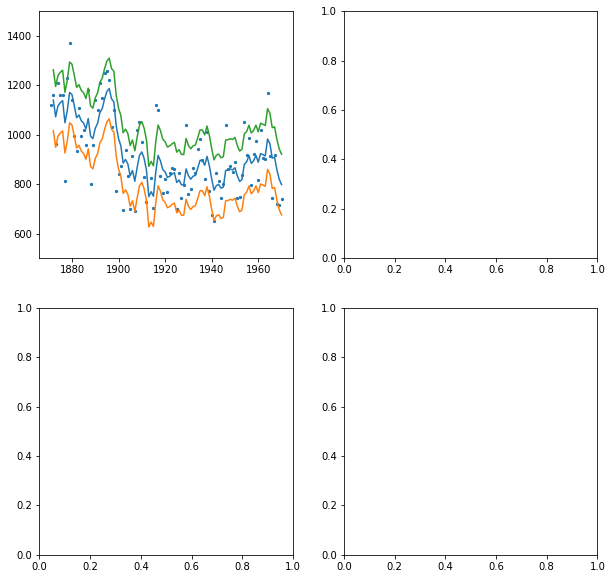

In [78]:
def Kalman_filter(df, P1, a1, sigma_e, sigma_n):
    a = a1
    P = P1

    df_kf = pd.DataFrame(columns=['a', 'P', 'v', 'F', 'K'])
    for i,y in enumerate(df['Nile']):
        v = y - a
        F = P + sigma_e
        K = P/F
        
        att = a + K*v
        Ptt = P*(1 - K) 

        a_pred = att
        P_pred = Ptt + sigma_n

        a = a_pred
        P = P_pred
        if i > 0:
            row = [a_pred, P_pred, v, F, K]
            df_kf.loc[i] = row

    df_kf['a_err'] = sigma_e**0.5
    return df_kf

df_kf = Kalman_filter(df=df, P1=10**7, a1=0, sigma_e = 15099, sigma_n = 1469.1)

fig, axs = plt.subplots(2,2, figsize=(10,10))

# upper left
ax = axs[0,0]
ax.scatter(df['year'], df['Nile'], s=5)
ax.plot(df['year'][1:], df_kf['a'])
ax.plot(df['year'][1:], df_kf['a']-df_kf['a_err'])
ax.plot(df['year'][1:], df_kf['a']+df_kf['a_err'])
ax.set_ylim(500, 1500)

# lower left
ax = axs[1,0]
ax.plot(df['year'][1:], df_kf['v'][1:])
ax.hlines(y = 0, xmin= df['year'].min(), xmax=df['year'].max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df['year'], df_kf['P'])


# lower right
ax = axs[1,1]
ax.plot(df['year'][1:], df_kf['F'][1:])

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


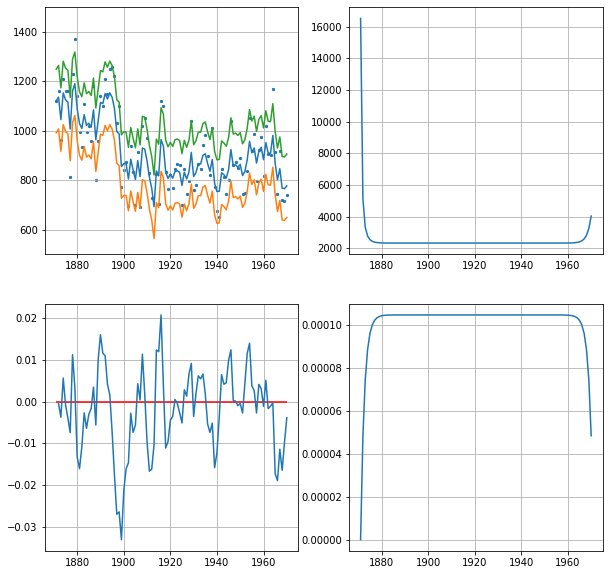

In [72]:
def Kalman_smoother(df, P1, a1, sigma_e, sigma_n, r_int, N_int):
    df_kf = Kalman_filter(df, P1, a1, sigma_e, sigma_n)
    
    # df_kf = df_kf.reindex(index=df_kf.index[::-1]).reset_index(drop=True)
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    
    df_ks = pd.DataFrame(columns=['r', 'alpha', 'N', 'V'])

    r = r_int
    N = N_int
    for i in range(len(df_kf)):
        r = df_kf['F'][i]**-1 * df_kf['v'][i] + (1-df_kf['K'][i])*r
        alpha = df_kf['a'][i] + df_kf['P'][i]*r
        N = df_kf['F'][i]**-1 + (1-df_kf['K'][i])**2 * N
        V = df_kf['P'][i] - df_kf['P'][i]**2 * N

        row = [r, alpha, N, V]
        df_ks.loc[i] = row

    df_ks['a_err'] = V**0.5

    # df_ks = df_ks.reindex(index=df_kf.index[::-1]).reset_index(drop=True)
    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    return df_ks

df_ks = Kalman_smoother(df=df, P1=10**7, a1=0, sigma_e = 15099, sigma_n = 1469.1, r_int = 0, N_int = 0)


fig, axs = plt.subplots(2,2, figsize=(10,10))

# upper left
ax = axs[0,0]
ax.scatter(df['year'], df['Nile'], s=5)
ax.plot(df['year'], df_ks['alpha'])
ax.plot(df['year'], df_ks['alpha']-df_ks['a_err'])
ax.plot(df['year'], df_ks['alpha']+df_ks['a_err'])
ax.set_ylim(500, 1500)

# lower left
ax = axs[1,0]
ax.plot(df['year'][1:], df_ks['r'][1:])
ax.hlines(y = 0, xmin= df['year'].min(), xmax=df['year'].max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df['year'], df_ks['V'])


# lower right
ax = axs[1,1]
ax.plot(df['year'], df_ks['N'])

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


In [62]:
print(df)

    year  Nile
0   1871  1120
1   1872  1160
2   1873   963
3   1874  1210
4   1875  1160
..   ...   ...
95  1966   746
96  1967   919
97  1968   718
98  1969   714
99  1970   740

[100 rows x 2 columns]
